# 导入数据和库

In [1]:
import numpy as np
import pandas as pd
df_heart = pd.read_csv("heart.csv")
df_heart.head()    # 读取前五行

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
df_heart.target.value_counts()    # 输出分类值以及各个类别数目

target
1    165
0    138
Name: count, dtype: int64

# 第一个改进点，增加哑变量，提高分类能力

In [3]:
# 拆分出哑变量
a = pd.get_dummies(df_heart['cp'], prefix = "cp")
b = pd.get_dummies(df_heart['thal'], prefix = "thal")
c = pd.get_dummies(df_heart['slope'], prefix = "slope")
# 添加哑变量
frames = [df_heart, a, b, c]
df_heart = pd.concat(frames, axis = 1)
df_heart = df_heart.drop(columns = ['cp', 'thal', 'slope'])  # 删除原有的种类变量
df_heart.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,False,False,True,False,True,False,False,True,False,False
1,37,1,130,250,0,1,187,0,3.5,0,...,False,True,False,False,False,True,False,True,False,False
2,41,0,130,204,0,0,172,0,1.4,0,...,True,False,False,False,False,True,False,False,False,True
3,56,1,120,236,0,1,178,0,0.8,0,...,True,False,False,False,False,True,False,False,False,True
4,57,0,120,354,0,1,163,1,0.6,0,...,False,False,False,False,False,True,False,False,False,True


# 展示数据状况

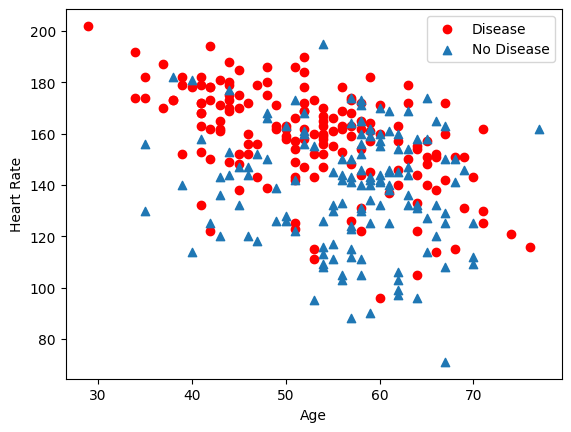

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=df_heart.age[df_heart.target==1], y=df_heart.thalach[df_heart.target==1], c="red")
plt.scatter(x=df_heart.age[df_heart.target==0], y=df_heart.thalach[df_heart.target==0], marker="^")
plt.legend(["Disease","No Disease"])
plt.xlabel("Age")
plt.ylabel("Heart Rate")
plt.show()

In [5]:
x = df_heart.drop(['target'], axis = 1)
y = df_heart.target.values    # 此时y为（303，）
y = y.reshape(len(y),1)
print("张量x的形状：", x.shape)
print("张量y的形状：", y.shape)

张量x的形状： (303, 21)
张量y的形状： (303, 1)


# 构建逻辑回归模型

## 设定划分数据集的随机数种子为1

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)    # 此时对于训练集来说不能有测试集的特征，因此要先拟合再转换归一化
x_test = scaler.transform(x_test)

In [8]:
# 定义sigmoid函数，输入z，返回y'
def sigmoid(z):
    y_hat = 1/(1 + np.exp(-z))
    return y_hat

In [9]:
# 定义损失函数
def loss_function(x, y, w, b):
    y_hat = sigmoid(np.dot(x, w) + b)    # sigmoid逻辑函数 + 线性函数(wx+b)得到y'
    loss = -((y*np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))    # 计算损失
    cost = np.sum(loss) / x.shape[0]    # 整个数据集的平均损失
    return cost    # 返回整个数据集的平均损失

In [10]:
# 定义梯度下降的函数
def gradient_descent(x, y, w, b, lr, iteration):
    l_history = np.zeros(iteration)    # 记录梯度下降过程中中损失的数组
    w_history = np.zeros((iteration, w.shape[0], w.shape[1]))    # 记录梯度下降过程中权重的数组
    b_history = np.zeros(iteration)    # 记录梯度下降过程中偏置的数组
    for i in range(iteration):     # 进行机器训练迭代
        y_hat = sigmoid(np.dot(x, w) + b)
        derivative_w = np.dot(x.T, (y_hat-y)) / x.shape[0]    # 给权重向量求导
        derivative_b = np.sum(y_hat-y)/x.shape[0]    # 给偏置求导
        w = w - lr * derivative_w    # 更新权重向量
        b = b - lr * derivative_b    # 更新偏置
        l_history[i] = loss_function(x, y, w, b)    # 梯度下降中的损失
        # print("轮次", i+1, "当前轮训练损失：", l_history[i])
        w_history[i] = w    # 梯度下降中权重的记录
        b_history[i] = b    # 梯度下降中偏置的记录
    return l_history, w_history, b_history

In [11]:
# 定义预测函数
def predict(x, w, b):
    z = np.dot(x, w)    # 线性函数
    y_hat = sigmoid(z)    # 逻辑函数转换
    y_pred = np.zeros((y_hat.shape[0], 1))    # 初始化预测结果变量
    for i in range(y_hat.shape[0]):
        if y_hat[i, 0] < 0.5:
            y_pred[i, 0] = 0    # 如果预测概率小于0.5，输出分类0
        else:
            y_pred[i, 0] = 1    # 如果预测概率大于0.5，输出分类1
    return y_pred

In [12]:
# 定义逻辑回归模型
def logistic_regression(x, y, w, b, lr, iterations):
    l_history, w_history, b_history = gradient_descent(x, y, w, b, lr, iterations)    # 梯度下降
    print("训练最终损失：", l_history[-1])    # 输出最终损失
    y_pred = predict(x, w_history[-1], b_history[-1])    # 进行预测
    training_acc = 100 - np.mean(np.abs(y_pred - y_train)) * 100    # 计算准确率
    print("逻辑回归训练准确率：{:.2f}%".format(training_acc))
    return l_history, w_history, b_history

# 第二个改进点，根据绘制图像降低迭代次数，提高泛化能力

In [13]:
# 初始化参数
dimension = x.shape[1]    # len(x)是矩阵的行数目， 维度是列的数目
weight = np.full((dimension, 1), 0.1)    # 权重向量
bias = 0    # 偏置值
alpha = 1    # 学习速率
iterations = 200    # 迭代次数

In [14]:
# 用逻辑回归训练机器
loss_history ,weight_history, bias_history = logistic_regression(x_train, y_train, weight ,bias, alpha, iterations)

训练最终损失： 0.340621378091289
逻辑回归训练准确率：86.79%


In [15]:
y_pred = predict(x_test, weight_history[-1], bias_history[-1])    # 预测测试集
testing_acc = 100 - np.mean(np.abs(y_pred - y_test))*100    # 计算准确率
print("逻辑回归测试准确率：{:.2f}%".format(testing_acc))

逻辑回归测试准确率：82.42%


# 验证模型

In [16]:
%matplotlib inline    
# matplotlib魔术指令，显示内嵌图像
plt.rcParams["font.sans-serif"] = ["SimHei"] #解决中文字符乱码的问题
plt.rcParams["axes.unicode_minus"] = False #正常显示负号

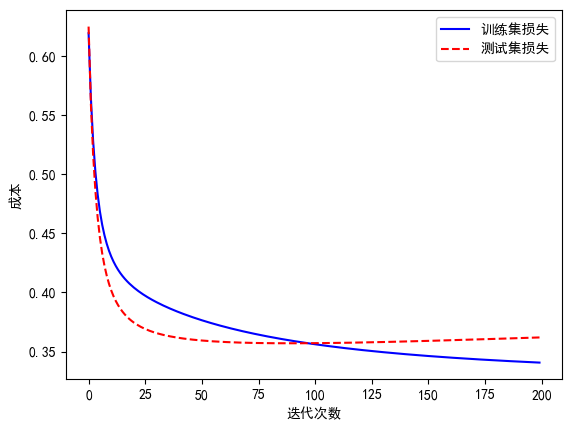

In [17]:
# 绘制损失曲线
loss_history_test = np.zeros(iterations)    # 初始化历史损失
for i in range(iterations):
    loss_history_test[i] = loss_function(x_test, y_test, weight_history[i], bias_history[i])
index = np.arange(0, iterations, 1)
plt.plot(index, loss_history, c='blue', linestyle='solid')
plt.plot(index, loss_history_test, c='red', linestyle='dashed')
plt.legend(["训练集损失", "测试集损失"])
plt.xlabel("迭代次数")
plt.ylabel("成本")
plt.show()

# 第三个改进点，直接调用sklearn写好的逻辑回归模型

In [18]:
# skearn函数库调用
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()            # lr，逻辑回归模型
lr.fit(x_train, y_train.ravel())     # fit, 梯度下降
print("SK learn逻辑回归测试准确率{:.2f}%".format(lr.score(x_test, y_test.ravel())*100))

SK learn逻辑回归测试准确率82.42%


# 第四个改进点，加入L2正则化，提高泛化能力

In [19]:
# 加入L2正则化
L2_lr = LogisticRegression(penalty = 'l2', C = 0.5)    # lr，逻辑回归模型
L2_lr.fit(x_train, y_train.ravel())                  # fit, 梯度下降
print("SK learn逻辑回归测试准确率{:.2f}%".format(L2_lr.score(x_test, y_test.ravel())*100))

SK learn逻辑回归测试准确率81.32%


# 尝试更多的机器学习算法

## 随机森林

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 123)
rf.fit(x_train, y_train.ravel())  # 训练模型
print("SK learn随机森林测试准确率{:.2f}%".format(rf.score(x_test, y_test.ravel())*100))

SK learn随机森林测试准确率82.42%


随机森林在此处表现并不出色，因此再尝试其他办法

# 第六个改进点，用网格搜索超参数调优

In [21]:
from sklearn.model_selection import StratifiedGroupKFold  # 导入K折验证工具
from sklearn.model_selection import GridSearchCV          # 导入网格搜索工具

parameters = {'C': (0.01, 0.1, 1, 10)}
grid_search = GridSearchCV(LogisticRegression(), parameters,  verbose=0, scoring='accuracy', cv=5)
grid =grid_search.fit(x_train, y_train.ravel())
print('最佳效果：{:.3f}'.format(grid_search.best_score_))
best_parameters= grid_search.best_estimator_.get_params()
print('最佳参数：\n', best_parameters)

最佳效果：0.849
最佳参数：
 {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [22]:
print("最终，在使用了各种办法尝试以后，对随机种子为1划分的数据进行逻辑回归")
print("SK learn逻辑回归测试准确率{:.2f}%".format(grid_search.best_score_*100))

最终，在使用了各种办法尝试以后，对随机种子为1划分的数据进行逻辑回归
SK learn逻辑回归测试准确率84.94%


# 结论

以上，便是能做到的最后结果，如果需要更进一步，需要考虑的方向不是从模型入手，而是要从数据入手。

考虑根据专业知识进行特征工程，以及获取更多的数据用以提高模型的参数优化。

但是模型已经由原始的68.85％的准确率提升到86％的准确率，取得了较为明显的进步，说明所做的工作还是有效的